### CV Assignment 6

Pragya Jaiswal (MDS202129)

## Imports and uploading image

In [1]:
import numpy as np
import cv2, math
from skimage.util import random_noise
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
!rm *.zip
!gdown 15H1fktvRVaoGs13K7k0vw-zysmF4tDLi
!unzip CV_images.zip

rm: cannot remove '*.zip': No such file or directory
Downloading...
From: https://drive.google.com/uc?id=15H1fktvRVaoGs13K7k0vw-zysmF4tDLi
To: /content/CV_images.zip
100% 17.9M/17.9M [00:00<00:00, 62.7MB/s]
Archive:  CV_images.zip
  inflating: fingerprint2.jpg        
  inflating: notch3.jpg              
  inflating: monastery.jpg           
  inflating: Pisa.jpg                
  inflating: fingerprint3.png        
  inflating: fingerprint4.png        
  inflating: fingerprint1.jpg        
  inflating: fingerprint5.png        
  inflating: building.jpg            
  inflating: market.jpg              
  inflating: hawamahal2.jpg          
  inflating: hawamahal1.jpg          
  inflating: CinqueTerre.jpg         
  inflating: bookpage.jpg            
  inflating: notch1.jpg              
  inflating: Colors.png              
  inflating: panda.jpeg              
  inflating: checkerboard.png        
  inflating: notch2.png              
  inflating: objects.png             
  inflati

In [3]:
##Helper function

def disp_subplots(image, shape, titles, sup_title, axes, figsize, cmap=None):
  fig, ax = plt.subplots(shape[0], shape[1], figsize=figsize)
  try:
    ax = ax.ravel()
  except:
    pass
    
  for i in range(len(image)):
    if cmap is None:
      ax[i].imshow(image[i])
    else:
      ax[i].imshow(image[i], cmap=cmap)

    if axes[i] is None:
      ax[i].set_xticks([])
      ax[i].set_yticks([])

    if titles[i] is not None:
      ax[i].set_title(titles[i])

  if sup_title is not None:
    fig.suptitle(sup_title, fontsize=18)
  plt.show()

##Question 1

In [4]:
# Reading the image
img = cv2.imread('checkerboard.png', 0)

### Part (a)

In [5]:
## Adding Gaussian Noise
noise_gauss_img = random_noise(img, mode = 'gaussian')* 255.0
noise_gauss_img = noise_gauss_img.astype(np.uint8)

## Adding salt & pepper noise
noise_sp_img = random_noise(img, mode = 's&p')* 255
noise_sp_img = noise_sp_img.astype(np.uint8)

## Adding periodic noise

def add_periodic_noise(image):

  X, Y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))

  # Define the period and amplitude of the noise
  period = 10
  amplitude = 50

  # Compute the noise signal
  noise = amplitude * np.sin(2 * np.pi * X / period)

  # Add the noise signal to the input image
  noisy_img = image + noise

  return np.float32(noisy_img)

noise_pd_img = add_periodic_noise(img)


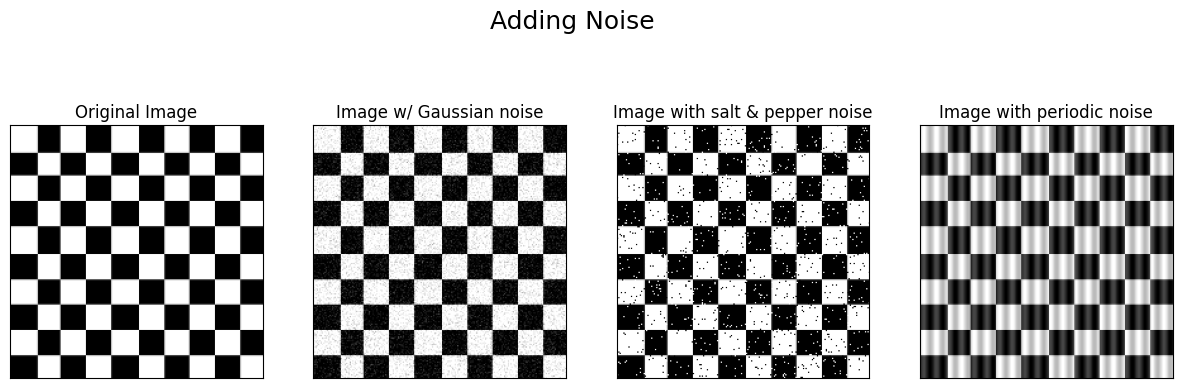

In [6]:
## Plotting 
disp_subplots([img, noise_gauss_img, noise_sp_img, noise_pd_img], (1,4), 
              ['Original Image', 'Image w/ Gaussian noise', 'Image with salt & pepper noise', 'Image with periodic noise'],
              "Adding Noise", [None]*4, (15,5),cmap = 'gray'
)

### Part (b)

In [7]:
#smoothing gaussian filter, median filter and the notch filter (for periodic noise)

def denoise(img,title):
  
  gauss_filter = cv2.GaussianBlur(noise_gauss_img,(5,5),0)
  median_filter = cv2.medianBlur(img,3)
  box_filter = cv2.blur(img,(5,5))
  bilateral_filter = cv2.bilateralFilter(img,9,75,75)
  
  disp_subplots([gauss_filter, median_filter, box_filter, bilateral_filter], (1,4), 
              ['Gaussian Filter', 'Median Filter', 'Box Filter', 'Bilateral Filter'], title, [None]*4, (15,5),cmap = 'gray'
)

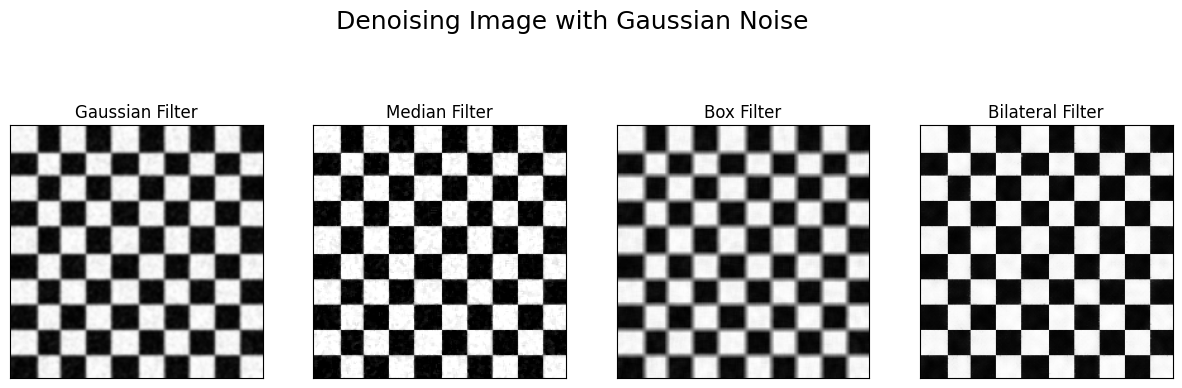

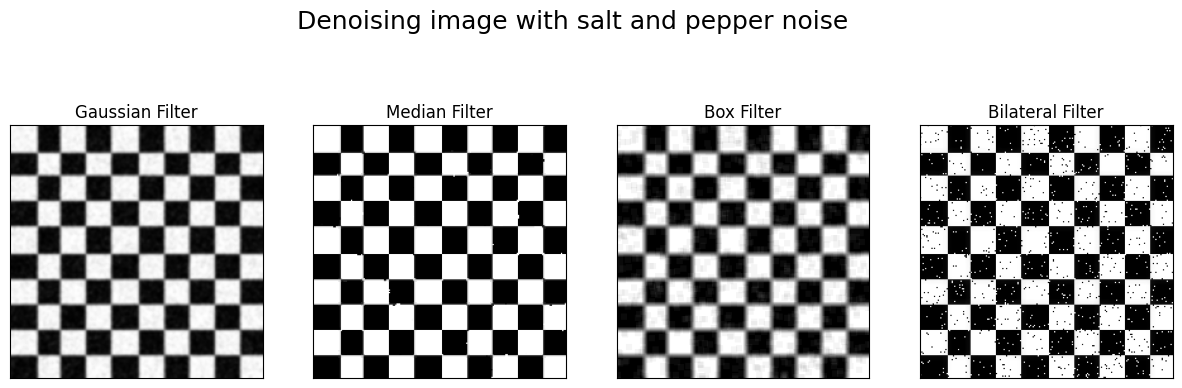

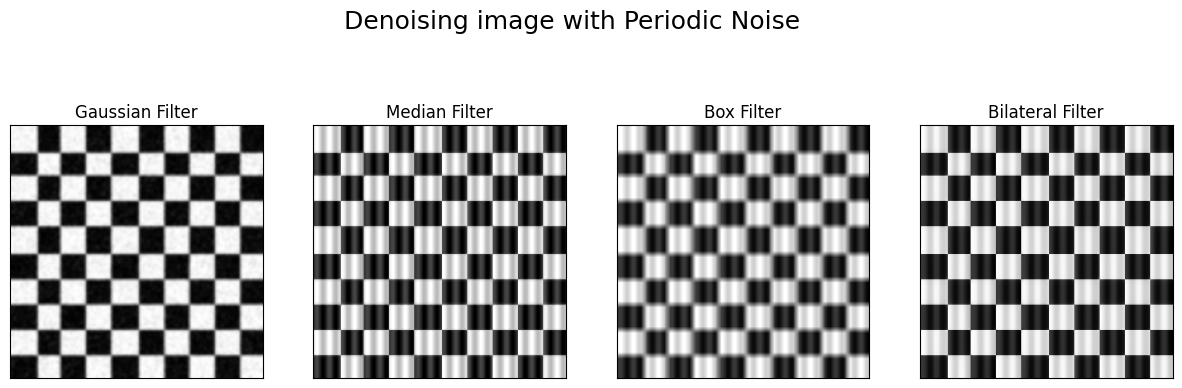

In [8]:
denoise(noise_gauss_img, 'Denoising Image with Gaussian Noise')
denoise(noise_sp_img, "Denoising image with salt and pepper noise")
denoise(noise_pd_img, "Denoising image with Periodic Noise")


**Observation:** 
1. *Gaussian noise:* Bilateral Filter performs best. Median filter although not as clear, does a considerably good job at denoising. Box filter and gaussian filter despite removing noise, make the image very blurred.

2. *Salt and Pepper noise:* Median filter performs best. Bilateral filter performs worst. Box filter and Gaussian filters denoise considerably but make the images very blurry.

3. *Periodic Noise:* Gaussian filter removes the noise considerably. Other filters fail to remove the noise.

In [30]:
def get_fshift_and_save_dft(img):
  img = np.asarray(img)
  f = np.fft.fft2(img)
  fshift = np.fft.fftshift(f)
  dft = 20 * np.log(np.abs(fshift))
  dft = cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)
  dft_shift = np.fft.fftshift(dft)

  magnitude_spectrum, phase_spectrum = cv2.cartToPolar(dft_shift[:,:,0],dft_shift[:,:,1])
  magnitude_spectrum_new = 20*np.log(1 + magnitude_spectrum)
  result = np.where(magnitude_spectrum_new == np.amax(magnitude_spectrum_new))
  result  = magnitude_spectrum_new.argsort(axis=-1, kind=None, order=None)[-9:][::-1]
  
  points =[]
  for i in range(9):
    highest, high_index = -1, 0.1
    for ind_i,i in enumerate(magnitude_spectrum_new):
      for ind_j,j in enumerate(i):
        if j>highest and not((ind_i, ind_j) in points):
          highest= j
          high_index=(ind_i, ind_j)
    points.append(high_index)

  return points[1:]


# Applying Ideal-Notch Filter
def ideal_notch(img):
  img = np.asarray(img)
  f = np.fft.fft2(img)
  fshift = np.fft.fftshift(f)
  dft, d0 = 20 * np.log(np.abs(fshift)), 0.5
  M, N  = fshift.shape
  
  points = get_fshift_and_save_dft(img.copy())
  for u in range(M):
    for v in range(N):
      for d in range(len(points)):
        u0, v0 = points[d][0], points[d][1]
        d1 = ((u- M/2 -u0)**2 +(v- N/2 - v0)**2)**(1/2)
        d2 = ((u- M/2 +u0)**2 +(v- N/2 + v0)**2)**(1/2)
        # d1 = pow(pow(u - u0, 2) + pow(v - v0, 2), 1)
        # d2 = pow(pow(u + u0, 2) + pow(v + v0, 2), 1)
        if d1 <= d0 or d2 <= d0:
          fshift[u][v] *= 0.0
  f_ishift = np.fft.ifftshift(fshift)
  return np.abs(np.fft.ifft2(f_ishift))


# Applying Butterworth-Notch Filter
def butter_notch(img):
  img = np.asarray(img)
  f = np.fft.fft2(img)
  fshift = np.fft.fftshift(f)
  dft, d0, eps = 20 * np.log(np.abs(fshift)), 0.5, 0.000001
  points = get_fshift_and_save_dft(img.copy())
  
  M, N = fshift.shape
  for u in range(M):
    for v in range(N):
      for d in range(len(points)):
        u0, v0 = points[d][0], points[d][1]
        d1 = pow(pow(u - u0, 2) + pow(v - v0, 2), 0.5)
        d2 = pow(pow(u + u0, 2) + pow(v + v0, 2), 0.5) 
        fshift[u][v] *= (1.0 / (1 + pow((d0 * d0) / (d1 * d2 + eps), 1))) 
  f_ishift = np.fft.ifftshift(fshift)
  return np.abs(np.fft.ifft2(f_ishift))

#defining the Gaussian notch filter
def gauss_notch(img):
  img = np.asarray(img)
  f = np.fft.fft2(img)
  fshift = np.fft.fftshift(f)
  dft, d0 = 20 * np.log(np.abs(fshift)), 0.5
  points = get_fshift_and_save_dft(img.copy())

  M, N = fshift.shape
  for u in range(M):
    for v in range(N):
      for d in range(len(points)):
        u0, v0 = points[d][0], points[d][1]
        d1 = pow(pow(u - u0, 2) + pow(v - v0, 2), 0.5)
        d2 = pow(pow(u + u0, 2) + pow(v + v0, 2), 0.5)
        fshift[u][v] *= (1 - math.exp(-0.5 * (d1 * d2 / pow(d0, 2))))

  f_ishift = np.fft.ifftshift(fshift)
  return np.abs(np.fft.ifft2(f_ishift))

In [31]:
def apply_notch_filter(img):
  ideal_notch_img = ideal_notch(img)
  gauss_notch_img = gauss_notch(img)
  bw_notch_img = butter_notch(img)

  disp_subplots([img,ideal_notch_img, gauss_notch_img, bw_notch_img], (1,4), 
              ['Image w/ periodic noise', 'Ideal notch filter', 'Gaussian notch filter', 'Butterworth notch filter'], "Applying Notch filters to image with periodic noise", [None]*4, (15,5),cmap = 'gray'
)

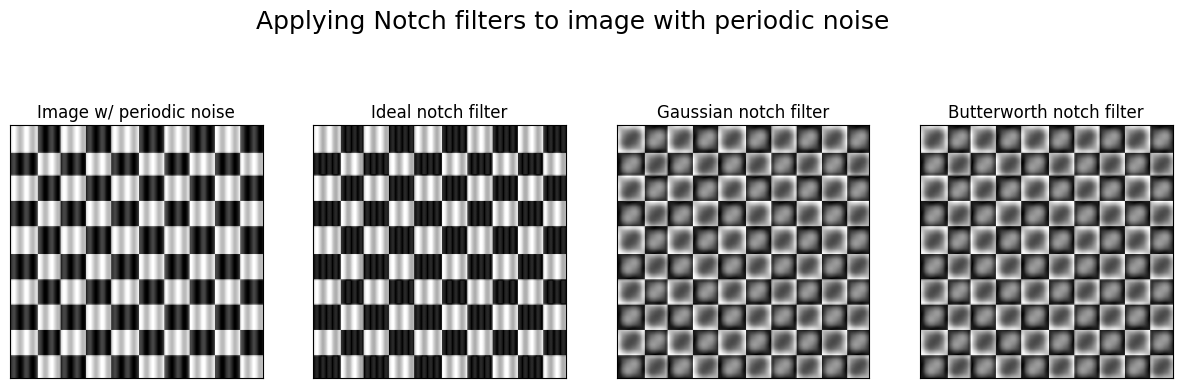

In [32]:
apply_notch_filter(noise_pd_img)

The notch filters do not perform as well as it was expected to.

In [14]:
img_notch1 = cv2.imread('notch1.jpg', 0)
img_notch2 = cv2.imread('notch2.png', 0)
img_notch3 = cv2.imread('notch3.jpg', 0)

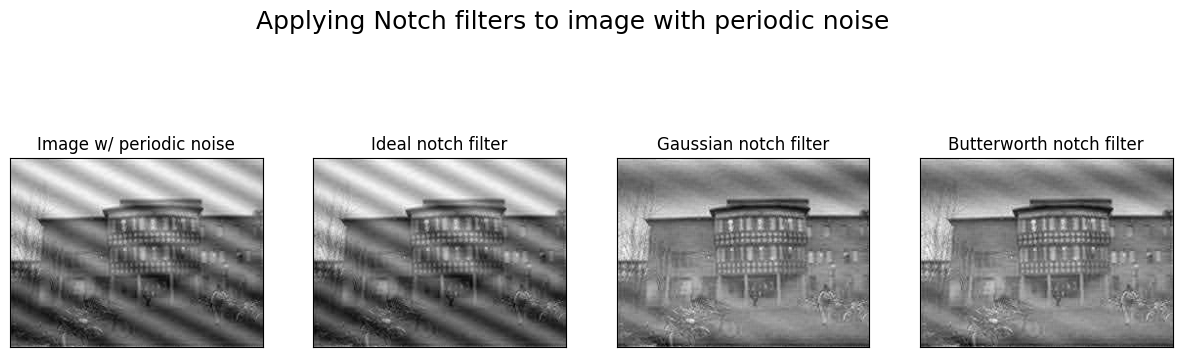

In [16]:
apply_notch_filter(img_notch1)

Gaussian notch filter and Butterworth notch filter perform better than Ideal notch filter.

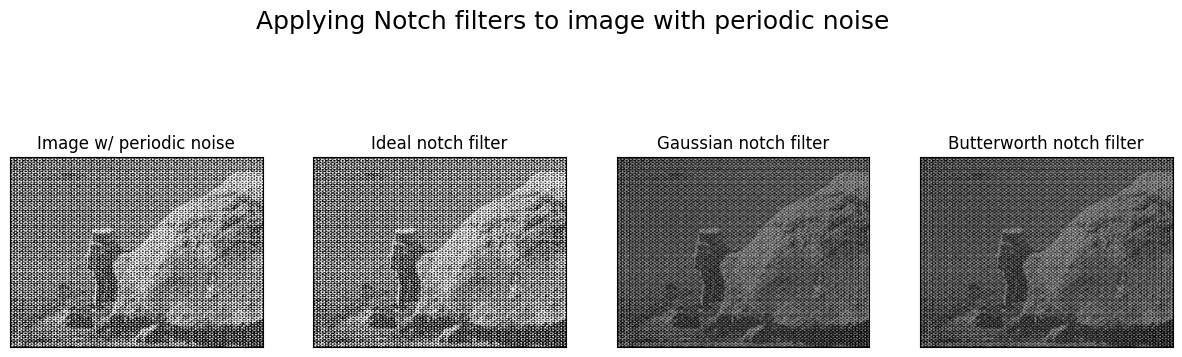

In [17]:
apply_notch_filter(img_notch2)

The notch filters do not help in denoising the images.

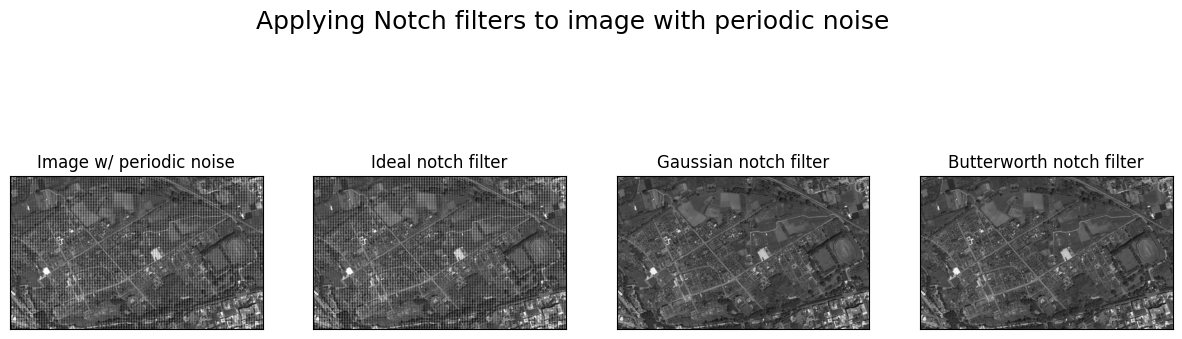

In [18]:
apply_notch_filter(img_notch3)

The Gaussian notch filter and butterworth notch filter almost completely remove the noise while ideal notch filter fails at it.

## Q2

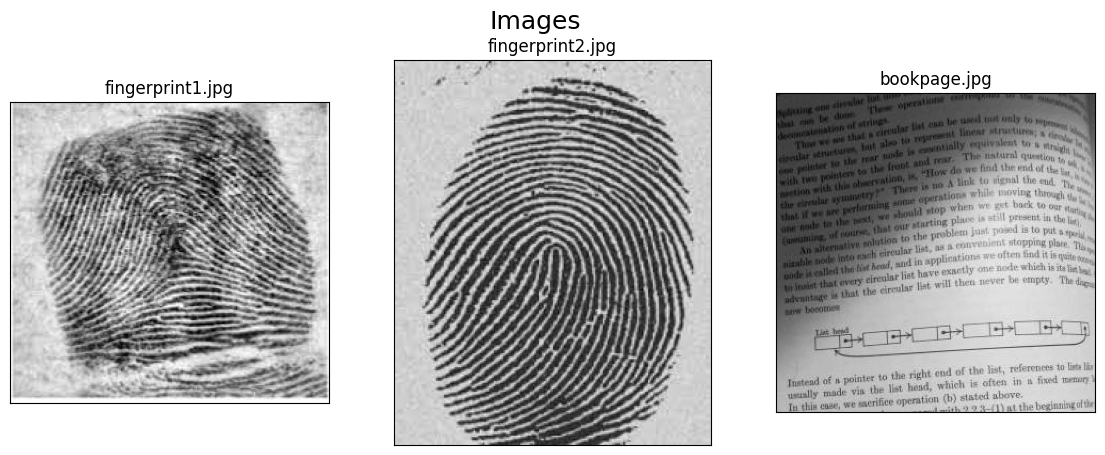

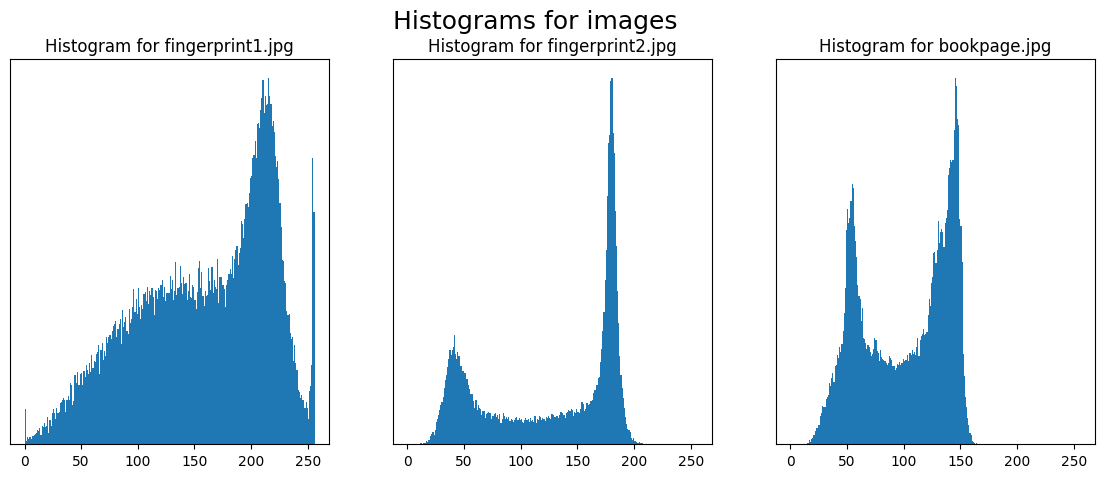

In [44]:
fp_img1 = cv2.imread('fingerprint1.jpg', 0)
fp_img2 = cv2.imread('fingerprint2.jpg', 0)
bp_img = cv2.imread('bookpage.jpg', 0)

# Creating a list of the above images
im_list = [fp_img1, fp_img2, bp_img]
names = ["fingerprint1.jpg","fingerprint2.jpg","bookpage.jpg"]

disp_subplots(im_list,(1,3), names, 'Images' ,[None]*3, (14,5), cmap = 'gray')
# Plotting histograms for each of the above image
fig, ax = plt.subplots(1,3, figsize = (14,5))
for i in range(3):
  ax[i].set_yticks([])
  ax[i].hist(im_list[i].ravel(), 256, [0,256])
  ax[i].set_title(f"\nHistogram for {names[i]}")
fig.suptitle('Histograms for images', fontsize=18)
plt.show()

### Part(a) Manual Thresholding


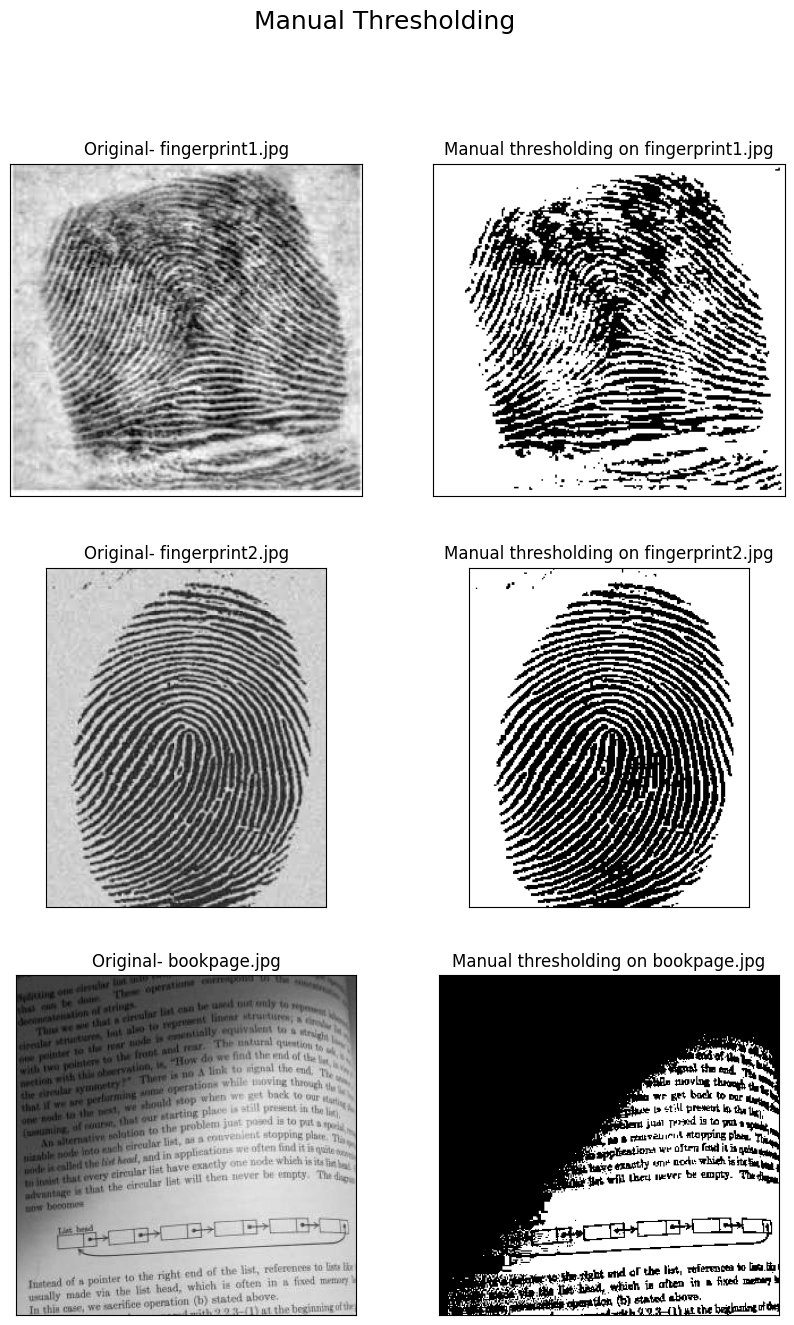

In [55]:
t = [127,127,127]
imgs, titles, ret1, th1 = [], [], [], []

for i in range(3):
  imgs.append(im_list[i])
  titles.append(f'Original- {names[i]}')

  ret1.append(cv2.threshold(im_list[i], t[i], 255, cv2.THRESH_BINARY)[0])
  th1.append(cv2.threshold(im_list[i], t[i], 255, cv2.THRESH_BINARY)[1])
  imgs.append(th1[i])
  titles.append(f'Manual thresholding on {names[i]}')

disp_subplots(imgs, (3,2), titles, 'Manual Thresholding', [None]*6,
              (10,15), 'gray')

**Observation:** It works well for fingerprints but not for book page.

### Part (b) Global Thresholding

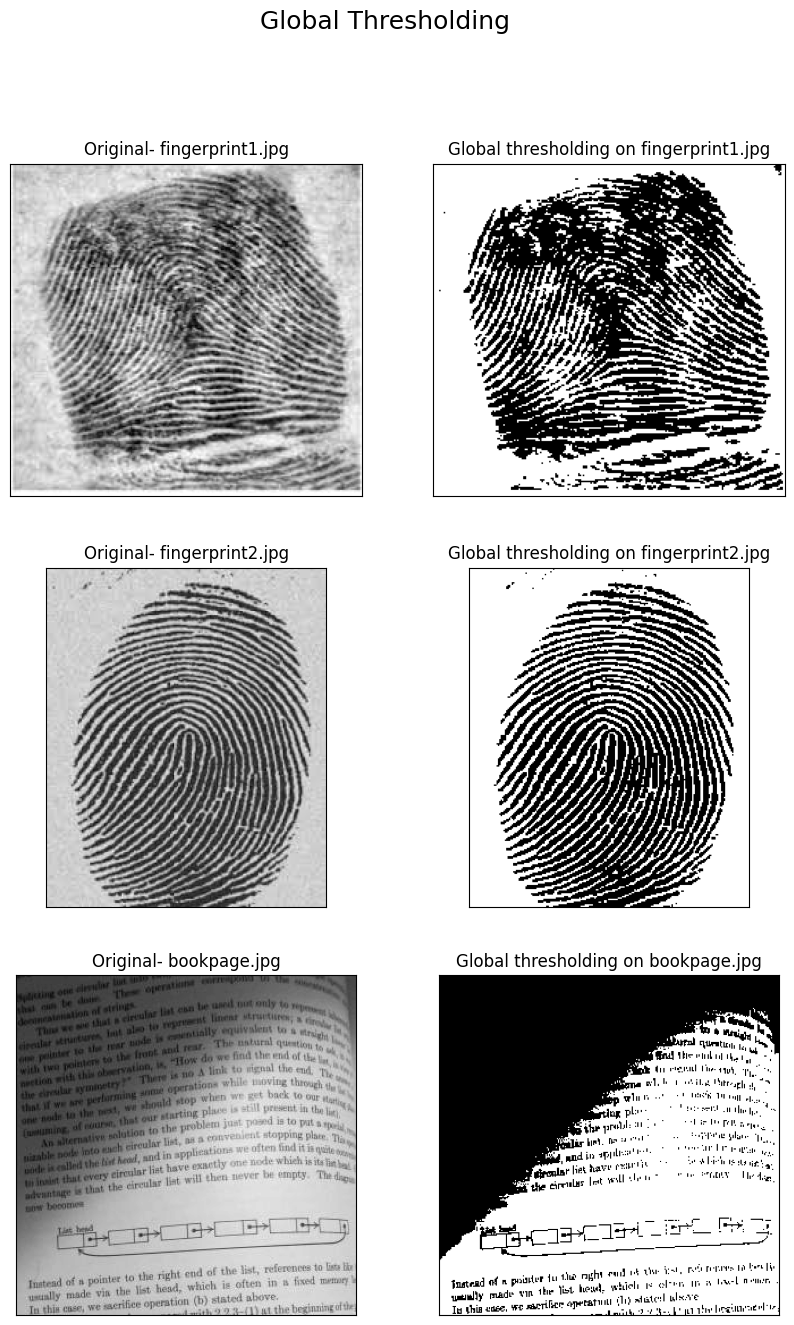

In [51]:

#listing the threshold values
t = [150,120,100]
imgs, titles, ret1, th1 = [], [], [], []

for i in range(3):
  imgs.append(im_list[i])
  titles.append(f'Original- {names[i]}')

  ret1.append(cv2.threshold(im_list[i], t[i], 255, cv2.THRESH_BINARY)[0])
  th1.append(cv2.threshold(im_list[i], t[i], 255, cv2.THRESH_BINARY)[1])
  imgs.append(th1[i])
  titles.append(f'Global thresholding on {names[i]}')

# Displaying results
disp_subplots(imgs, (3,2), titles, 'Global Thresholding', [None]*6,
              (10,15), 'gray')

**Observation:** It works well for fingerprints but not for book page.

### Part (c) Otsu's Thresholding

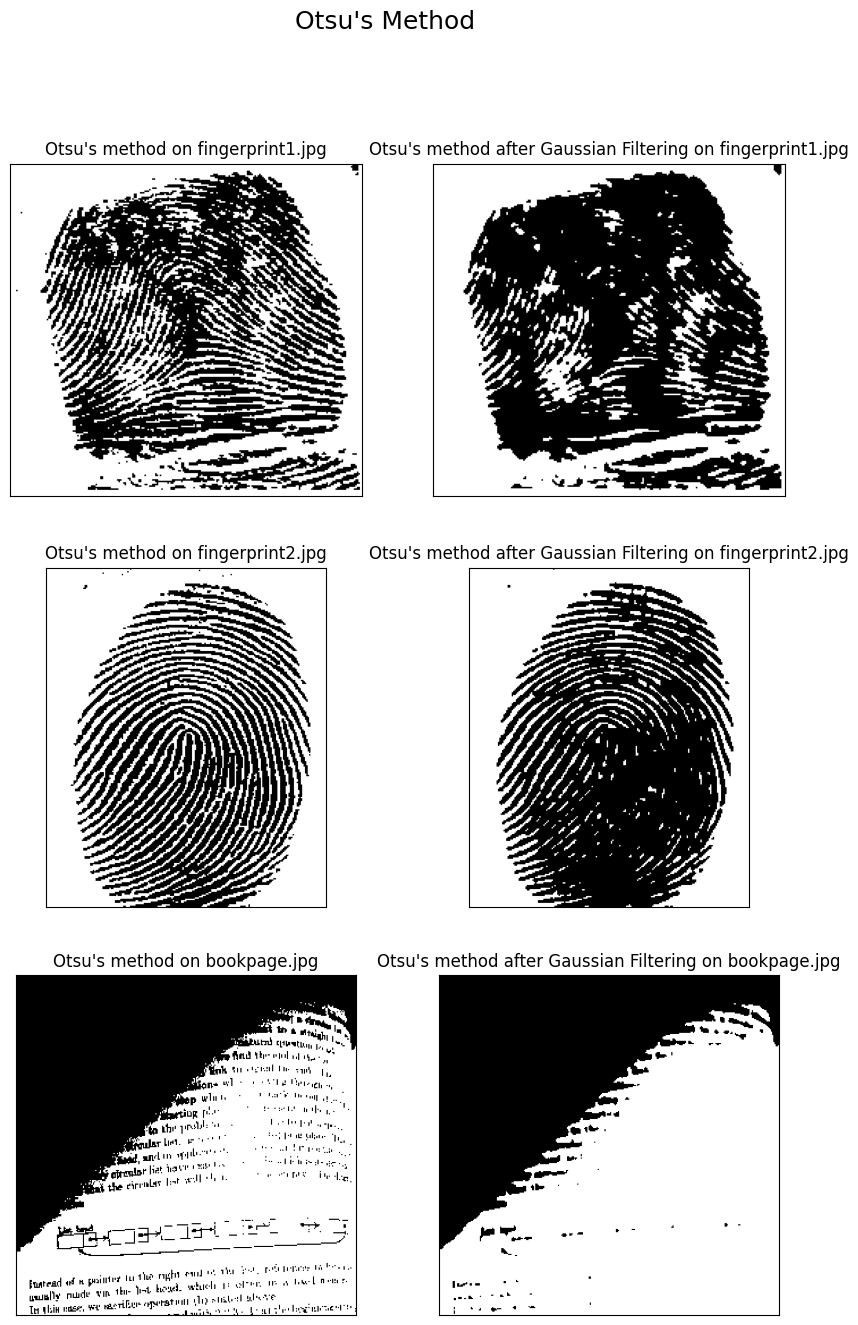

In [52]:

imgs, titles = [], []
for i in range(3):
  imgs.append(cv2.threshold(im_list[i],0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1])
  titles.append(f"Otsu's method on {names[i]}")

  blur = cv2.GaussianBlur(im_list[i],(5,5),0)
  imgs.append(cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1])
  titles.append(f"Otsu's method after Gaussian Filtering on {names[i]}")

# Displaying results
disp_subplots(imgs, (3,2), titles, "Otsu's Method", [None]*6,
              (10,15), 'gray')
     

**Observation:** Otsu's method on original image is working better than applying the same on the Gaussian filtered image.

### Part (d) Adaptive Thresholding

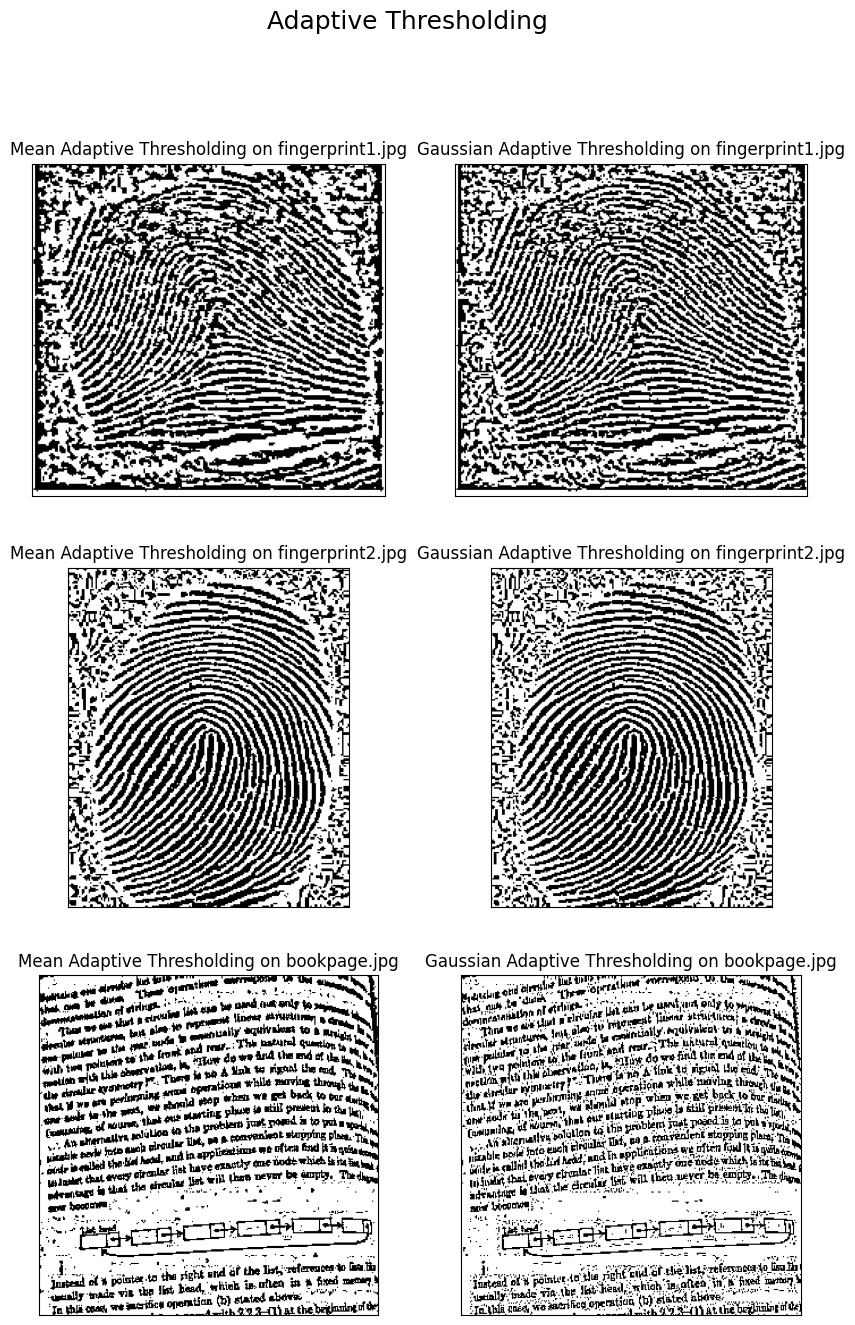

In [ ]:

imgs, titles = [], []
for i in range(3):
  # Mean adaptive thresholding
  imgs.append(cv2.adaptiveThreshold(im_list[i],255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2))
  titles.append(f"Mean Adaptive Thresholding on {names[i]}")

  # Gaussian adaptive thresholding
  imgs.append(cv2.adaptiveThreshold(im_list[i],255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2))
  titles.append(f"Gaussian Adaptive Thresholding on {names[i]}")

# Displaying results
disp_subplots(imgs, (3,2), titles, "Adaptive Thresholding", [None]*6,
              (10,15), 'gray')

**Observation:** From the above results we conclude that for the images fingerprint1.jpg and fingerprint2.jpg, global thresholding method and Otsu's method have worked better than adaptive thresholding methods, with Otsu's method providing slightly better results than global thresholding. This may be due to the fact that in case of global thresholding, we had set a threshold value manually ourselves, whereas on the contrary, in Otsu's method we measure the effectiveness of thresholding using the ratio of variances.

On the other hand, for the image bookpage.jpg, the adaptive thresolding methods (both mean and Gaussian) is working better than the rest of the methods we applied. Visually judging, we can conclude that mean-adaptive thresholding is working slighly better than the Gaussian alternative by removing more noise.

## Q3

### Part (a) Sobel Transform

In [67]:
def app_sob(img):
  sobel_x = cv2.flip(np.array([[-1,0,1],[-2,0,2],[-1,0,1]]), -1)
  sobel_y = cv2.flip(np.array([[-1,-2,-1],[0,0,0],[1,2,1]]), -1)
  sob_x = cv2.filter2D(img, -1, sobel_x)
  sob_y = cv2.filter2D(img, -1, sobel_y)
  return (0.5* sob_x) + (0.5*sob_y)

# Thresholding image
def app_threshold(img, threshold=25):
  M,N = img.shape
  output = np.zeros((M,N))
  for i in range(M):
    for j in range(N):
      if img[i,j]>threshold:
        output[i,j] = 255
  return output

# Applying LoG filtering
def app_log(img):
  img_den = cv2.GaussianBlur(img, (3, 3), 1.5)
  return cv2.Laplacian(img_den, cv2.CV_64F)

# Applying zero-crossing
def zero_crossing(image):
  z_c_image = np.zeros(image.shape)

  '''  
  For each pixel, count the number of positive
  and negative pixels in the neighborhood
  '''
  for i in range(1, image.shape[0] - 1):
    for j in range(1, image.shape[1] - 1):
      neg, pos = 0, 0
      neighbour = [image[i+1, j-1],image[i+1, j],image[i+1, j+1],image[i, j-1],image[i, j+1],image[i-1, j-1],image[i-1, j],image[i-1, j+1]]
      d, e = max(neighbour), min(neighbour)
      for h in neighbour:
        if h>0:
          pos += 1
        elif h<0:
          neg += 1

      '''
       If both negative and positive values exist in 
       the pixel neighborhood, then that pixel is a 
       potential zero crossing
      '''
            
      z_c = ((neg > 0) and (pos > 0))
      '''
       Change the pixel value with the maximum neighborhood
       difference with the pixel
      '''

      if z_c:
        if image[i,j]>0:
          z_c_image[i, j] = image[i,j] + np.abs(e)
        elif image[i,j]<0:
          z_c_image[i, j] = np.abs(image[i,j]) + d
                
  # Normalize and change datatype to 'uint8' (optional)
  z_c_norm = z_c_image/z_c_image.max()*255
  z_c_image = np.uint8(z_c_norm)
  return z_c_image

# Adding periodic noise to image
def period_noise(image):
  M, N = img.shape[0], img.shape[1]
  noise = np.zeros((M,N), dtype='float64')
  X, Y = np.meshgrid(range(0, M), range(0, N))
  A, u0, v0 = 40, 45, 50
  noise += A*np.sin(X*u0 + Y*v0)
  A, u0, v0 = -18, -45, 50
  noise += A*np.sin(X*u0 + Y*v0)
  periodic_noise = img+noise
  return np.float32(periodic_noise)


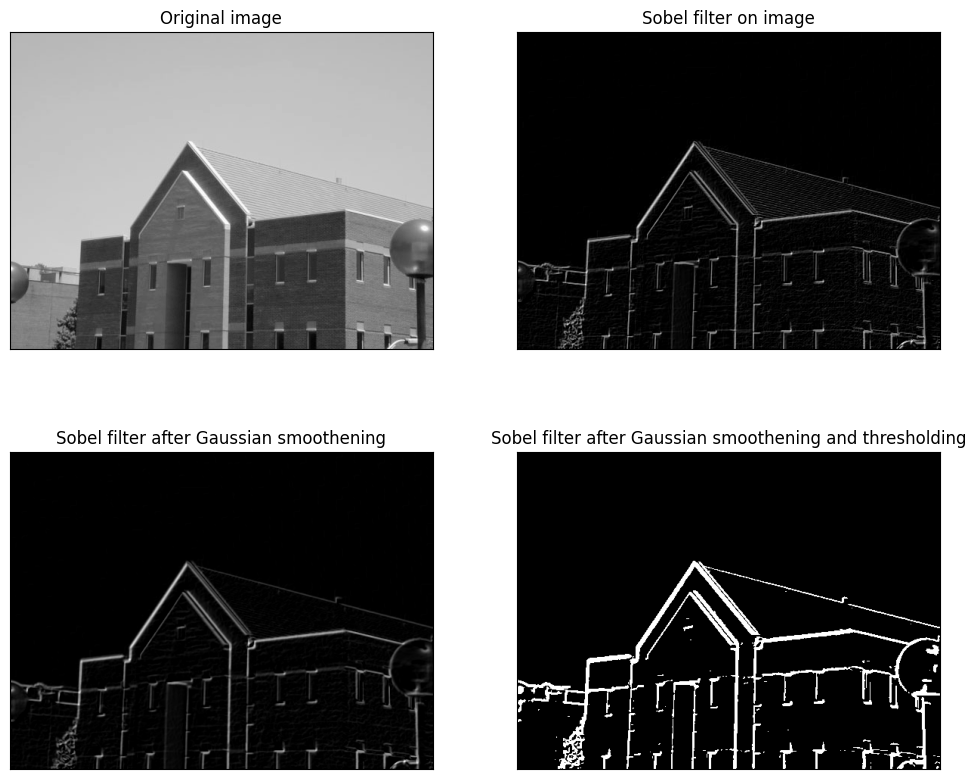

In [68]:
# Reading building.jpg
img = cv2.imread('building.jpg', 0)
# Gaussian Smooothening
img_noise_rem = cv2.GaussianBlur(img, (3, 3), 1.5)

# Applying sobel filter
sob_img = app_sob(img)
sob_img_noise_rem = app_sob(img_noise_rem)
sob_img_threshold = app_threshold(sob_img_noise_rem)

# Displaying results
disp_subplots([img, sob_img, sob_img_noise_rem, sob_img_threshold], (2,2),
              ['Original image', 'Sobel filter on image', 
               'Sobel filter after Gaussian smoothening',
               'Sobel filter after Gaussian smoothening and thresholding'],
               None, [None]*4, (12,10), cmap='gray')

### Part (b) LoG Transform

In [69]:
# Applying LoG
log_img = app_log(img)
# Applying zero-crossing
zc_log = zero_crossing(log_img)
# Applying thresholding
zc_log = app_threshold(zc_log, threshold = 35)

     

### Part (c) Canny Edge Detection

In [70]:

# Canny edge detection
smooth = cv2.GaussianBlur(img, (3,3), 1.5)
canny = cv2.Canny(img, 40, 150)

###Part (d) Hough Transform

In [71]:

# Hough Transform
hough_image = cv2.GaussianBlur(img, (3,3), 1.5)
edges = cv2.Canny(hough_image, 50, 200, apertureSize = 3)
lines = cv2.HoughLinesP(edges, 2, np.pi/180, threshold = 150, minLineLength=100, 
                        maxLineGap=250)

# Draw lines on the image
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(hough_image, (x1, y1), (x2, y2), (255, 0, 0), 3)

### For Object.jpg

In [ ]:
# Reading objects.jpg
img2 = cv2.imread('objects.png', 0)
# Gaussian Smooothening
img_noise_rem2 = cv2.GaussianBlur(img2, (3, 3), 1.5)

# Applying sobel filter
sob_img2 = app_sob(img2)
sob_img_noise_rem2 = app_sob(img_noise_rem2)
sob_img_threshold2 = app_threshold(sob_img_noise_rem2)

# Applying LoG
log_img2 = app_log(img2)
# Applying zero-crossing
zc_log2 = zero_crossing(log_img2)
# Applying thresholding
zc_log2 = app_threshold(zc_log2, threshold = 35)

# Canny edge detection
smooth2 = cv2.GaussianBlur(img2, (3,3), 1.5)
canny2 = cv2.Canny(img2, 40, 150)

# Hough Transform
hough_image2 = cv2.GaussianBlur(img2, (3,3), 1.5)
edges2 = cv2.Canny(hough_image2, 50, 200, apertureSize = 3)
lines2 = cv2.HoughLinesP(edges2, 2, np.pi/180, threshold = 150, minLineLength=100, 
                        maxLineGap=250)

# Draw lines on the image
for line in lines2:
    x1, y1, x2, y2 = line[0]
    cv2.line(hough_image2, (x1, y1), (x2, y2), (255, 0, 0), 3)

### Displaying results for building.jpg and objects.jpg

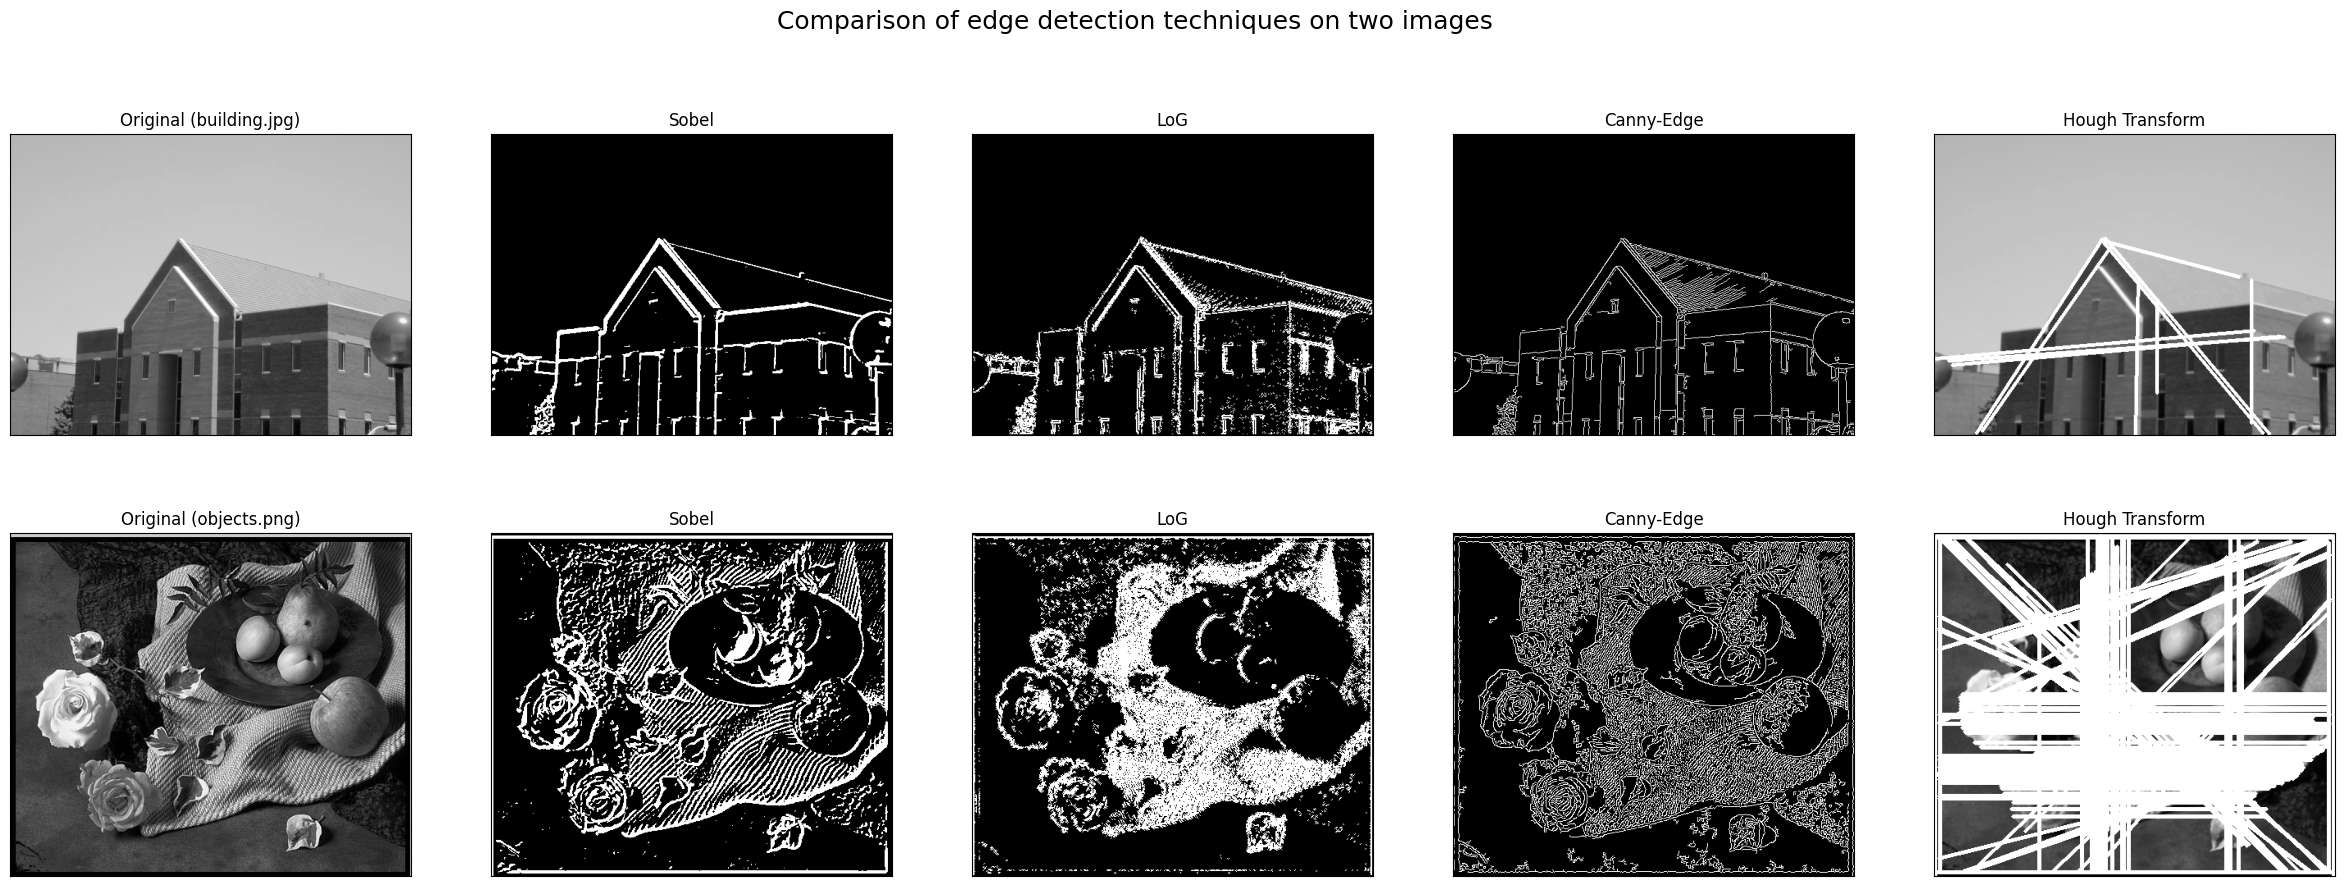

In [73]:
# Displaying results
disp_subplots([img, sob_img_threshold, zc_log, canny, hough_image,
               img2, sob_img_threshold2, zc_log2, canny2, hough_image2], (2,5),
              ['Original (building.jpg)', 'Sobel', 'LoG', 'Canny-Edge', 'Hough Transform',
               'Original (objects.png)', 'Sobel', 'LoG', 'Canny-Edge', 'Hough Transform'],
               'Comparison of edge detection techniques on two images', [None]*10, (30,10), cmap='gray')


**Observation:** By visual comparison we immediately conclude that Canny Edge Detection works the best for building.jpg. From the above results we also observe that for building.jpg, Hough transform has been able to detect the lines since the image has very well-defined straight lines.

On the other hand, for the image objects.png, Hough transform fails terribly in edge-detection since the image contains mostly circular and curved objects with non-linear edges. For such an image we may implement Hough transform for circular edge detection.

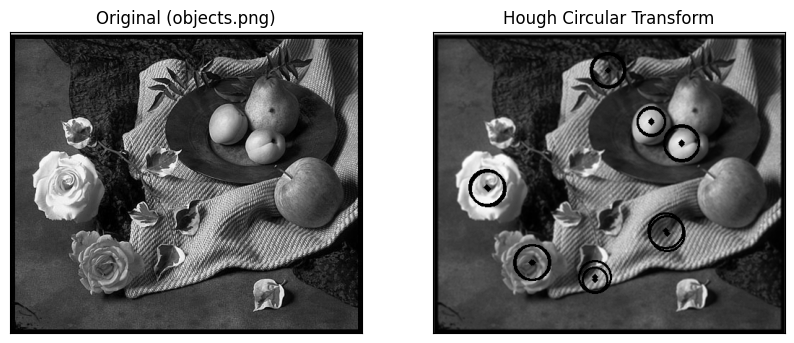

In [75]:

# Hough transform to detect circular edges
circles = cv2.HoughCircles(img_noise_rem2, cv2.HOUGH_GRADIENT, 1, 20,
                            param1=50, param2=30, minRadius=10, maxRadius=25)
circles = np.uint16(np.around(circles))
for i in circles[0,:]:
  # draw the outer circle
  cv2.circle(img_noise_rem2, (i[0],i[1]), i[2], (0,255,0), 2)
  # draw the center of the circle
  cv2.circle(img_noise_rem2, (i[0],i[1]), 2, (0,0,255), 3)
    
# Displaying results
disp_subplots([img2, img_noise_rem2], (1,2),
              ['Original (objects.png)', 'Hough Circular Transform'],
               None, [None]*2, (10,6), cmap='gray')